In [1]:
import gmsh
import dolfinx.io.gmshio
import dolfinx.mesh
from mpi4py import MPI
import pyvista
import dolfinx.plot

# --- Gmsh mesh generation ---
# Initialize Gmsh (only on the rank that will generate the mesh, typically rank 0)
gmsh_model_rank = 0
comm = MPI.COMM_WORLD
mesh = None # Initialize mesh to None

if comm.rank == gmsh_model_rank:
    gmsh.initialize()
    gmsh.option.setNumber("General.Terminal", 0) # Suppress Gmsh output
    model = gmsh.model
    model.add("annulus")
    model.setCurrent("annulus")

    # Define inner and outer radii
    inner_radius = 0.5
    outer_radius = 1.0
    mesh_size = 0.05 # Adjust for mesh density (made slightly finer)

    # Create points (optional for circles, but good practice)
    # center = model.geo.addPoint(0, 0, 0, mesh_size)
    # p_inner = model.geo.addPoint(inner_radius, 0, 0, mesh_size)
    # p_outer = model.geo.addPoint(outer_radius, 0, 0, mesh_size)

    # Create circles (using OpenCASCADE kernel)
    # addCircle returns the curve tag
    c_outer = model.occ.addCircle(0, 0, 0, outer_radius)
    c_inner = model.occ.addCircle(0, 0, 0, inner_radius) # Inner circle tag will likely be c_outer + 1

    # --- Corrected part: Create Curve Loops from the circles ---
    # addCurveLoop expects a list of curve tags
    loop_outer = model.occ.addCurveLoop([c_outer])
    loop_inner = model.occ.addCurveLoop([c_inner])
    # -------------------------------------------------------

    # Create surfaces from the curve loops
    # addPlaneSurface expects a list of curve loop tags
    # The first loop defines the outer boundary, subsequent loops define holes
    annulus_surface = model.occ.addPlaneSurface([loop_outer, loop_inner])


    # Synchronize the OCC model with the Gmsh model
    model.occ.synchronize()

    # Add physical group for the domain (the annulus surface)
    domain_tag = 1
    # annulus_surface[0][1] gets the tag of the created surface entity
    model.addPhysicalGroup(2, [annulus_surface], domain_tag) # Use the surface tag directly
    model.setPhysicalName(2, domain_tag, "annulus_domain")

    # Add physical groups for boundaries (inner and outer circles)
    outer_boundary_tag = 10
    inner_boundary_tag = 20
    # getEntitiesForPhysicalGroup returns entities belonging to physical group
    # Here we need the curve tags directly for the boundaries
    # We can tag the original circles before creating surfaces/loops
    model.addPhysicalGroup(1, [c_outer], outer_boundary_tag)
    model.setPhysicalName(1, outer_boundary_tag, "outer_boundary")
    model.addPhysicalGroup(1, [c_inner], inner_boundary_tag)
    model.setPhysicalName(1, inner_boundary_tag, "inner_boundary")


    # Generate the 2D mesh
    model.mesh.generate(2)

    print("Gmsh mesh generated on rank 0.")

# Convert the Gmsh model (on rank 0) to a DOLFINx mesh (distributed)
# The dolfinx.io.gmshio.model_to_mesh function handles MPI distribution

# model_to_mesh expects the Gmsh model to be passed as the first argument
# and the rank where the model was created.
mesh, cell_tags, facet_tags = dolfinx.io.gmshio.model_to_mesh(
    model=gmsh.model,
    comm=comm,
    rank=gmsh_model_rank,
    gdim=2 # Geometric dimension
)
mesh.name = "annulus_mesh"

gmsh.finalize()

Gmsh mesh generated on rank 0.


In [2]:
# --- PyVista Visualization ---

# Convert DOLFINx mesh to PyVista UnstructuredGrid
# dolfinx.plot requires a newer version of dolfinx
# Note: vtk_mesh function might vary slightly between dolfinx versions
cells, types, x = dolfinx.plot.vtk_mesh(mesh)
grid = pyvista.UnstructuredGrid(cells, types, x)

# Create a plotter
plotter = pyvista.Plotter()

# Add the mesh - you can color by cell/facet tags if they were created and converted
# If you want to visualize the boundaries, you might need to extract them
# using mesh tags and potentially create separate mesh objects or use PyVista's filtering
plotter.add_mesh(grid, show_edges=True, color='lightblue')

# # Set view for 2D mesh
plotter.view_xy()
plotter.reset_camera()

# # Display the plot
plotter.show()

Widget(value='<iframe src="http://localhost:42063/index.html?ui=P_0x7fbe8e35d6a0_0&reconnect=auto" class="pyvi…

In [6]:
from mpi4py import MPI
import dolfinx
import numpy as np
import pyvista

In [10]:
from mpi4py import MPI
from dolfinx import mesh
domain = mesh.create_unit_square(MPI.COMM_WORLD, 8, 8, mesh.CellType.quadrilateral)

In [11]:
# visualize mesh
# --- PyVista Visualization ---

# Convert DOLFINx mesh to PyVista UnstructuredGrid
# dolfinx.plot requires a newer version of dolfinx
# Note: vtk_mesh function might vary slightly between dolfinx versions
cells, types, x = dolfinx.plot.vtk_mesh(domain)
grid = pyvista.UnstructuredGrid(cells, types, x)

# Create a plotter
plotter = pyvista.Plotter()

# Add the mesh - you can color by cell/facet tags if they were created and converted
# If you want to visualize the boundaries, you might need to extract them
# using mesh tags and potentially create separate mesh objects or use PyVista's filtering
plotter.add_mesh(grid, show_edges=True, color='lightblue')

# # Set view for 2D mesh
plotter.view_xy()
plotter.reset_camera()

# # Display the plot
plotter.show()

Widget(value='<iframe src="http://localhost:44355/index.html?ui=P_0x7f5080b98910_2&reconnect=auto" class="pyvi…

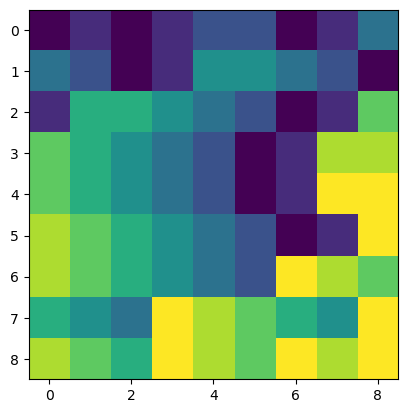

In [36]:
plt.imshow(x[:, 1].reshape(9,9))

In [12]:
from dolfinx.fem import functionspace
V = functionspace(domain, ("Lagrange", 1))

In [26]:
from dolfinx import fem
uD = fem.Function(V)
uD.interpolate(lambda x: x[0]+x[1])

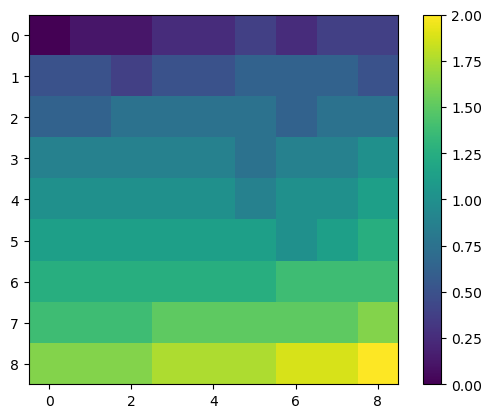

In [28]:
# visualize function uD with plt
import matplotlib.pyplot as plt
plt.imshow(uD.x.array.reshape(9,9))
plt.colorbar()

In [55]:
import numpy
# Create facet to cell connectivity required to determine boundary facets
tdim = domain.topology.dim
fdim = tdim - 1
domain.topology.create_connectivity(fdim, tdim) # connectivity between face and edge
boundary_facets = mesh.exterior_facet_indices(domain.topology) # determine boundary using the connectivity data

In [41]:
boundary_facets

array([  0,   1,   3,   5,   9,  13,  17,  23,  27,  35,  39,  49,  53,
        65,  69,  83,  86,  87, 100, 101, 102, 113, 114, 123, 124, 131,
       132, 137, 138, 141, 142, 143], dtype=int32)

In [56]:
boundary_dofs = fem.locate_dofs_topological(V, fdim, boundary_facets)
bc = fem.dirichletbc(uD, boundary_dofs)

In [58]:
boundary_dofs # boundary dof refers to the indices of nodes, while boundary_facets are indices of D-1 topological entities, in 2D case the edges

array([ 0,  1,  2,  4,  6,  8, 11, 13, 17, 19, 24, 26, 32, 34, 41, 43, 44,
       51, 52, 53, 59, 60, 65, 66, 70, 71, 74, 75, 77, 78, 79, 80],
      dtype=int32)

In [6]:
# 3. Function Spaces
# Vector function space for velocity
V = fem.FunctionSpace(mesh, ("Lagrange", 2), dim=2)
# Scalar function space for pressure
Q = fem.FunctionSpace(mesh, ("Lagrange", 1))
# Mixed function space for velocity and pressure
W = fem.FunctionSpace(mesh, fem.MixedElement([V.element, Q.element]))

TypeError: FunctionSpace.__init__() got an unexpected keyword argument 'dim'

In [3]:
# 4. Define the Finite Element Function Space for the Q-tensor
# In 2D, a symmetric traceless tensor Q = [[Qxx, Qxy], [Qxy, -Qxx]]
# can be represented by a 2-component vector [Qxx, Qxy]
# We'll use continuous Galerkin (CG) elements, degree 1 (P1) as a start
Q_element = basix.ufl.element("CG", mesh.basix_cell(), 1, shape=(2,))
V = dolfinx.fem.functionspace(mesh, Q_element)

NameError: name 'basix' is not defined

In [ ]:
# 5. Define Trial and Test Functions
Q = ufl.TrialFunction(V) # The unknown solution at time step n+1
V_test = ufl.TestFunction(V) # The test function

# 6. Define the solution at the previous time step
Q_n = dolfinx.fem.Function(V) # This will hold the solution from the previous step

# 7. Define the Variational Problem (Simplified)
# We'll implement the terms from:
# integral(1/dt * Q_n+1 . V dx) + integral(Gamma * grad(Q_n+1) : grad(V) dx) = integral(RHS_n . V dx) + boundary terms

# Placeholder for the RHS term (will be expanded later)
# For now, let's just set it to a zero tensor expression
# In a real simulation, this would include convection, molecular field, flow alignment etc.
class RHSTerm(dolfinx.fem.Expression):
    def __init__(self, Q_n, u_n, mesh, Gamma, dt, metadata=None):
        # Initialize with parameters needed to compute the RHS
        # For now, this placeholder just returns zero
        # In a real simulation, you'd use u_n, Q_n, Gamma, etc. here
        self._Q_n = Q_n # Example: previous Q
        self._u_n = u_n # Example: previous u (needs a function space defined later)
        self._Gamma = Gamma
        self._dt = dt
        self._mesh = mesh # Need mesh to access geometry, etc.
        if metadata is None:
            metadata = {}
        super().__init__(metadata=metadata)

    # Define the form evaluation for different points (needed by DOLFINx)
    # This simplified version always returns zero
    def _evaluate(self, x, cell_entities, c):
         # x.shape is (gdim, num_points)
         # c.shape is (num_points, value_size) - value_size is dim of element
         for i in range(c.shape[0]):
             # For a 2D vector space representing Q, value_size is 2
             c[i, 0] = 0.0 # Qxx component of RHS
             c[i, 1] = 0.0 # Qxy component of RHS

    @property
    def value_shape(self):
        # The shape of the output value at each point
        # Matches the dimension of the function space (V)
        return (2,) # For a 2-component vector space


# Instantiate the placeholder RHS term (u_n will be defined later)
# For now, pass None for u_n or define a dummy function
u_n_placeholder = dolfinx.fem.Function(dolfinx.fem.VectorFunctionSpace(mesh, ("CG", 1), dim=2)) # Dummy u_n
rhs_term = RHSTerm(Q_n, u_n_placeholder, mesh, Gamma, dt)


# Define the terms of the weak form using UFL
# Bilinear form: a(Q, V_test)
a = (1/dt) * ufl.inner(Q, V_test) * ufl.dx + \
    Gamma * ufl.inner(ufl.grad(Q), ufl.grad(V_test)) * ufl.dx

# Linear form: L(V_test)
# Includes the term from the previous time step Q_n and the RHS
L = (1/dt) * ufl.inner(Q_n, V_test) * ufl.dx + \
    ufl.inner(rhs_term, V_test) * ufl.dx # Add the RHS term


# 8. Boundary Conditions (Placeholder)
# For now, let's apply homogeneous Dirichlet conditions (Q = 0 on boundaries)
# This is usually NOT physically accurate for nematics, but simplifies the setup.
# We'll refine BCs later.

# Locate facets on the boundary (tagged by Gmsh)
# The Gmsh physical group tags for boundaries were 10 (outer) and 20 (inner)
fdim = mesh.topology.dim - 1 # Dimension of facets
boundary_facets = facet_tags.find(outer_boundary_tag)
boundary_facets = np.append(boundary_facets, facet_tags.find(inner_boundary_tag))

# Create a Dirichlet boundary condition object
# Value is a constant [0.0, 0.0] for Qxx=0, Qxy=0
Q_D = dolfinx.fem.Function(V) # Create a function to hold the boundary value
with Q_D.vector.localForm() as loc:
    loc.set(0.0) # Set all DoF values to 0.0

# Apply the boundary condition to the located facets
bc = dolfinx.fem.DirichletBC(Q_D, dolfinx.fem.locate_dofs_geometrical(V, lambda x: np.isclose(x[0], x[0])),
                              boundary_facets, mesh.topology.dim - 1) # Using lambda x: np.isclose(x[0], x[0]) is a dummy marker that is always true, applying BC to specified facets


bcs = [bc] # List of boundary conditions

# 9. Set up the Linear Solver
# For the time-implicit diffusion part, we have a linear system: A * Q = B
# where A is assembled from 'a', and B is assembled from 'L'
# We need to assemble the matrix A and vector B

problem = dolfinx.fem.petsc.LinearProblem(a, L, bcs=bcs, petsc_options={"ksp_type": "preonly", "pc_type": "lu"})

# 10. Time Stepping Loop
# Create a Function to store the solution at the current time step
Q_solution = dolfinx.fem.Function(V)

# Set initial condition (e.g., Q = 0 everywhere)
# A uniform Q=0 state might be an unstable equilibrium, need a small perturbation usually
Q_n.x.array[:] = 0.0 # Initialize Q_n to zero

print("Starting time stepping loop...")
time = 0.0
for i in range(num_steps):
    time += dt

    # Solve the linear system for Q_solution (which is Q^n+1)
    # The solver uses the forms 'a' and 'L' and boundary conditions 'bcs'
    # It solves A * Q_solution = B, where A and B are assembled based on the forms
    try:
        problem.solve(Q_solution)
    except Exception as e:
        print(f"Solver failed at time step {i+1}, time {time:.4f}: {e}")
        # You might want to break or handle the error
        break


    # Update Q_n for the next time step
    Q_n.x.array[:] = Q_solution.x.array[:]

    # Optional: Print progress
    if (i + 1) % 100 == 0:
        print(f"Completed time step {i+1}/{num_steps} at time {time:.4f}")

    # Optional: Save or visualize results periodically
    # This requires setting up output files (e.g., XDMFFile) or visualization
    # if (i + 1) % 100 == 0:
    #    # Add visualization/saving code here
    #    pass


print("Time stepping loop finished.")

# 11. Visualize the final solution (Optional)
# Using the pyvista setup from earlier
if mesh and Q_solution:
    print("Visualizing final solution...")
    try:
        # Q_solution is a vector function [Qxx, Qxy]
        # We might want to visualize scalar quantities like S^2 = Qij Qij
        # Or the orientation and magnitude

        # Simple visualization: plot the Qxx component
        # You would need to extract the component or define a scalar function space
        # For now, let's plot the magnitude ||Q||_F = sqrt(Qxx^2 + Qxy^2 + Qxy^2 + Qxx^2)
        # ||Q||_F = sqrt(2 * (Qxx^2 + Qxy^2))
        # Need to create a scalar function space and project/interpolate the magnitude

        # For demonstration, let's just plot the Qxx component (index 0 of the vector)
        # This requires extracting the component data correctly for plotting
        # A robust way is to project/interpolate into a scalar space

        # Create a scalar function space (P1)
        V_scalar = dolfinx.fem.FunctionSpace(mesh, ("CG", 1))
        # Create a scalar function for magnitude
        Q_magnitude = dolfinx.fem.Function(V_scalar)

        # Define a UFL expression for the magnitude
        # Need to access components of Q_solution
        Q_xx = ufl.real(Q_solution[0]) # Assuming Q_solution is complex, use real if needed
        Q_xy = ufl.real(Q_solution[1])
        magnitude_expr = ufl.sqrt(2 * (Q_xx**2 + Q_xy**2))

        # Project or interpolate the magnitude expression onto the scalar space
        # Interpolation is often simpler for visualization
        Q_magnitude.interpolate(dolfinx.fem.Expression(magnitude_expr, Q_solution.x.array.real.shape[0], mesh.geometry.cmap)) # Interpolate requires an Expression

        # A simpler interpolation method if available or suitable
        # Q_magnitude.interpolate(lambda x: np.sqrt(2 * (Q_solution(x)[0]**2 + Q_solution(x)[1]**2)))
        # Note: The lambda function approach might not work directly on dolfinx Functions in parallel/general cases.
        # Using the UFL expression with interpolate/project is more robust.

        # Let's create an Expression from the UFL expression for interpolation
        # The Expression needs to know the function space of the input (Q_solution)
        # This is a bit involved in DOLFINx. A common way is to evaluate the UFL expression
        # at the mesh vertices or DoFs and create a scalar function from those values.

        # --- Alternative simple visualization: plot the Qxx component directly if possible ---
        # This might depend on the dolfinx.plot version and pyvista compatibility
        # A safer way for PyVista is to attach scalar data
        # Let's get the DoF values for Qxx (first component)
        Qxx_values = Q_solution.x.array.real[0::2] # Assuming DoFs are ordered [Qxx0, Qxy0, Qxx1, Qxy1, ...]

        # Need to map DoF values to VTK points
        # This can be complex for non-vertex DoFs or in parallel
        # For P1 elements, DoFs are at vertices, so we can often map directly
        # However, dolfinx.plot.vtk_mesh gives the grid suitable for the function space

        cells_pv, types_pv, x_pv = dolfinx.plot.vtk_mesh(V) # Get grid for the function space V
        grid_pv = pyvista.UnstructuredGrid(cells_pv, types_pv, x_pv)

        # Attach Qxx values as scalar data
        grid_pv.point_data["Qxx"] = Q_solution.x.array.real[0::2] # Assuming DoF layout

        # Or attach magnitude values (if you computed Q_magnitude)
        # grid_pv.point_data["Magnitude_Q"] = Q_magnitude.x.array.real


        # Set the active scalar for coloring
        grid_pv.set_active_scalars("Qxx") # Color by Qxx

        plotter = pyvista.Plotter()
        # Add the mesh, colored by the active scalar
        plotter.add_mesh(grid_pv, show_edges=False, cmap='viridis') # show_edges=False often looks better with scalar data
        # Optionally add a wireframe of the mesh outline
        plotter.add_mesh(grid_pv.extract_all_edges(), color='black', line_width=1)


        plotter.view_xy()
        plotter.reset_camera()
        plotter.add_scalar_bar("Qxx") # Add a color bar

        plotter.show()


    except Exception as e:
        print(f"Error during final PyVista visualization: {e}")
        print("Could not visualize the final solution.")

Gmsh mesh generated on rank 0.
DOLFINx mesh created on rank 0.
Gmsh finalized on rank 0.


AttributeError: module 'dolfinx.fem' has no attribute 'VectorFunctionSpace'